## Загрузка


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"polinacher","key":"a241d6c303b034abeb741c7c5796777c"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d polinacher/diamonds-clear

  0% 0.00/470k [00:00<?, ?B/s]
100% 470k/470k [00:00<00:00, 126MB/s]


In [ ]:
! unzip  '/content/diamonds-clear.zip' -d '/content/diamonds-clear'

Archive:  /content/diamonds-clear.zip
  inflating: /content/diamonds-clear/diamonds_clear.csv  


## Подготовка

In [ ]:
import pandas as pd
import matplotlib
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split # разделение датасета на тренировочный и тестовый
import imblearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.ensemble import RandomForestClassifier

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/diamonds-clear/diamonds_clear.csv')
df

,carat,cut,color,clarity,depth percentage,table,price,length,width,depth
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
3,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
4,0.24,Very Good,J,VVS2,62.8,57.0,336.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...,...
42930,0.72,Ideal,D,SI1,60.8,57.0,2757.0,5.75,5.76,3.50
42931,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
42932,0.70,Very Good,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
42933,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


In [ ]:
"""def MultiColumnLabelEncoder(columns,df): #нормализация категориальных признаков
    X = df.iloc[:].values
    for i in range(len(columns)):
        X[:, columns[i]] = labelencoder.fit_transform(X[:, columns[i]])
    df = pd.DataFrame(X, columns=df.columns, index = df.index)
    return df

columns = [1,2,3]
df = MultiColumnLabelEncoder(columns,df)
df""""

,carat,cut,color,clarity,depth percentage,table,price,length,width,depth
0,0.23,2,1,3,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,326.0,3.89,3.84,2.31
2,0.29,3,5,5,62.4,58.0,334.0,4.2,4.23,2.63
3,0.31,1,6,3,63.3,58.0,335.0,4.34,4.35,2.75
4,0.24,4,6,7,62.8,57.0,336.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...,...
42930,0.72,2,0,2,60.8,57.0,2757.0,5.75,5.76,3.5
42931,0.72,1,0,2,63.1,55.0,2757.0,5.69,5.75,3.61
42932,0.7,4,0,2,62.8,60.0,2757.0,5.66,5.68,3.56
42933,0.86,3,4,3,61.0,58.0,2757.0,6.15,6.12,3.74


In [ ]:
df = df.drop('table', axis = 1) # удаление столбцов, имеющих нейтральную коррелляцию с ценой
df = df.drop('depth percentage', axis = 1)
df = df.drop('color', axis = 1)
df = df.drop('cut', axis = 1)
df = df.drop('clarity', axis = 1)


"""continuous_fields = ['carat','length', 'width', 'depth'] # нормировка непрерывных признаков
scaled_features = {} # сохранение мат. ожидания и дисперсии, чтобы потом обратить нормировку
for field in continuous_fields:
    mean, std = df[field].mean(), df[field].std()
    scaled_features[field] = [mean, std]
    df.loc[:, field] = (df[field] - mean)/std"""
df

,carat,price,length,width,depth
0,0.23,326.0,3.95,3.98,2.43
1,0.21,326.0,3.89,3.84,2.31
2,0.29,334.0,4.2,4.23,2.63
3,0.31,335.0,4.34,4.35,2.75
4,0.24,336.0,3.94,3.96,2.48
...,...,...,...,...,...
42930,0.72,2757.0,5.75,5.76,3.5
42931,0.72,2757.0,5.69,5.75,3.61
42932,0.7,2757.0,5.66,5.68,3.56
42933,0.86,2757.0,6.15,6.12,3.74


In [ ]:
df['price'].max() # максимальная цена

11856.0

In [ ]:
def divide_price(row): # разделение цены на категории
    if row['price'] >= 2000:
      row['price_limit'] = 1
    else:
      row['price_limit'] = 0
    return row

df = df.apply(divide_price, axis=1) # применение функции к каждой строке

df

,carat,price,length,width,depth,price_limit
0,0.23,326.0,3.95,3.98,2.43,0
1,0.21,326.0,3.89,3.84,2.31,0
2,0.29,334.0,4.20,4.23,2.63,0
3,0.31,335.0,4.34,4.35,2.75,0
4,0.24,336.0,3.94,3.96,2.48,0
...,...,...,...,...,...,...
42930,0.72,2757.0,5.75,5.76,3.50,1
42931,0.72,2757.0,5.69,5.75,3.61,1
42932,0.70,2757.0,5.66,5.68,3.56,1
42933,0.86,2757.0,6.15,6.12,3.74,1


In [ ]:
df['price_limit'].value_counts()

1    21778
0    21157
Name: price_limit, dtype: int64

In [ ]:
y = df['price_limit'] # целевая переменная
df = df.drop('price', axis = 1)
df = df.drop('price_limit', axis = 1)
df

,carat,length,width,depth
0,0.23,3.95,3.98,2.43
1,0.21,3.89,3.84,2.31
2,0.29,4.20,4.23,2.63
3,0.31,4.34,4.35,2.75
4,0.24,3.94,3.96,2.48
...,...,...,...,...
42930,0.72,5.75,5.76,3.50
42931,0.72,5.69,5.75,3.61
42932,0.70,5.66,5.68,3.56
42933,0.86,6.15,6.12,3.74


In [ ]:

X = pd.DataFrame(df, index = df.index, columns = df.columns) # данные для предсказания
X

,carat,length,width,depth
0,0.23,3.95,3.98,2.43
1,0.21,3.89,3.84,2.31
2,0.29,4.20,4.23,2.63
3,0.31,4.34,4.35,2.75
4,0.24,3.94,3.96,2.48
...,...,...,...,...
42930,0.72,5.75,5.76,3.50
42931,0.72,5.69,5.75,3.61
42932,0.70,5.66,5.68,3.56
42933,0.86,6.15,6.12,3.74


<Axes: xlabel='price_limit', ylabel='count'>

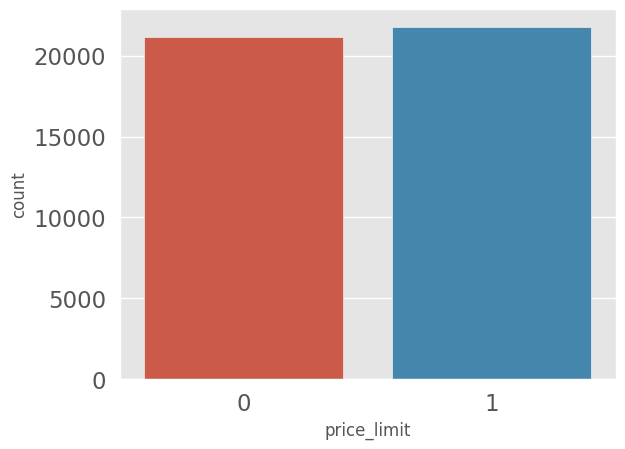

In [ ]:
 # определение несбалансированности классов
sns.countplot(x ='price_limit', data = df)

In [ ]:
y.value_counts()

1    21778
0    21157
Name: price_limit, dtype: int64

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)# stratify = y

<Axes: xlabel='price_limit', ylabel='count'>

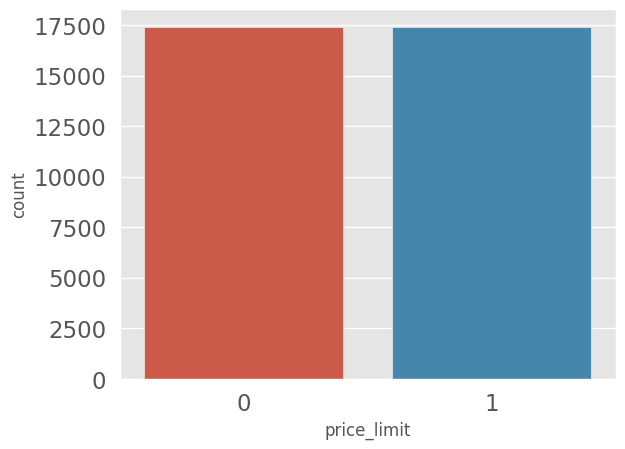

In [ ]:

from imblearn.over_sampling import SMOTE
oversample = SMOTE() # устранение дисбаланса классов
X_train, y_train = oversample.fit_resample(X_train, y_train)
sns.countplot(x = y_train, data = df)

## Gridsearch

RepeatedStratifiedKFold - это стратегия кросс-валидации, которая является комбинацией повторной (repeated) и стратифицированной (stratified) кросс-валидации. Эта стратегия используется для оценки производительности модели в машинном обучении. Она выполняет следующие шаги:
1. Набор данных разбивается на несколько поднаборов (фолдов), и каждый фолд содержит одинаковое или близкое к одинаковому количество примеров из каждого класса (стратификация). Это важно для обеспечения сбалансированности в распределении классов в каждом фолде.
2. После разбиения данных на фолды, проводится процедура обучения и оценки модели. Модель обучается на одних фолдах и оценивается на других.
3. Повторяются шаги 1 и 2 несколько раз с разными случайными разбиениями данных.
4. Результаты всех повторений собираются и используются для вычисления усредненных метрик производительности модели.

n_splits указывает на количество разбиений (фолдов)
<br>n_repeats указывает на количество повторений.







* refit определяет, следует ли переобучать модель на всем наборе данных после завершения поиска наилучших гиперпараметров. Если refit установлен в значение True, модель будет переобучена с использованием наилучших найденных гиперпараметров на всем наборе данных.
* cv (cross-validation) определяет количество разбиений (фолдов) для кросс-валидации при поиске наилучших гиперпараметров; кросс-валидация используется для оценки производительности модели на разных частях обучающего набора данных и помогает бороться с переобучением
* verbose определяет уровень подробности вывода во время выполнения поиска по сетке
* n_jobs определяет количество параллельно выполняемых задач; параметр контролирует, сколько ядер процессора используются для выполнения Grid Search и может ускорить процесс поиска по сетке:
<br> -1 означает использование всех доступных ядер процессора;
<br> положительное целое число, это означает количество ядер, которые будут задействованы для выполнения Grid Search.
* scoring  определяет метрику, которую Grid Search будет использовать для оценки производительности моделей при тестировании различных комбинаций гиперпараметров:
<br> - "accuracy" - точность
<br> - "f1" объединяет точность (precision) и полноту (recall) в одно значение
<br> - roc_auc позволяет оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак, и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак
* error_score  позволяет задать, как следует обрабатывать случаи, когда обучение модели приводит к ошибке;
<br> error_score = 0 означает, что если обучение модели завершается ошибкой, то вместо исключения будет возвращено значение 0, что может быть полезно для продолжения поиска по сетке даже при возникновении ошибок.


## Метод k-ближайших соседей + Gridsearch

n_neighbors - это параметр, который определяет количество ближайших соседей, которые будут учитываться при принятии решения о классификации или регрессии для нового наблюдения.
<br> Маленькое значение делает модель более чувствительной к выбросам и шуму в данных, что может привести к переобучению. Однако такая модель может лучше улавливать локальные закономерности в данных.
<br>Большее значение наоборот.

weights определяет, как веса для соседей будут учитываться при принятии решения.
<br>"uniform": в этом режиме все соседи имеют одинаковый вес, то есть каждый сосед учитывается с равным весом при принятии решения.
<br>"distance": в этом режиме вес соседей зависит от расстояния между новым наблюдением и соседними точками; ближайшие соседи получают больший вес, чем более удаленные соседи и оказывают большее влияние на решение.

algorithm определяет алгоритм, который будет использоваться для вычисления ближайших соседей.
<br>"auto" : алгоритм автоматически выбирает наиболее подходящий метод для вычисления ближайших соседей на основе входных данных и параметров.
<br>"ball_tree": используется структура данных "дерево шаров" для поиска ближайших соседей; этот метод может быть эффективным для наборов данных с большим количеством признаков.
<br>"kd_tree": используется структура данных "kd-дерево" для поиска ближайших соседей; этот метод также может быть эффективным для наборов данных с большим количеством признаков.
<br>"brute": выполняется "грубый" перебор всех обучающих примеров для поиска ближайших соседей; этот метод наименее эффективен, но может быть полезным для небольших наборов данных.

leaf_size  представляет собой размер листов в структуре данных, используемой для хранения обучающих примеров.
<br>Этот параметр влияет на эффективность поиска ближайших соседей. Значение leaf_size задает, сколько обучающих примеров может быть хранено в одном листе структуры данных. Выбор значения leaf_size зависит от размера набора данных и его характеристик.

p определяет метрику расстояния, которая будет использоваться для определения ближайших соседей.
<br>Если p=1, то используется манхэттенское расстояние. Это означает, что для вычисления расстояния между точками используется сумма абсолютных разностей координат по всем измерениям.
<br>Если p=2, то используется евклидово расстояние. В этом случае для вычисления расстояния между точками используется расстояние между ними как бы в прямой линии (гипотенуза в n-мерном пространстве).

In [ ]:
"""from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(
    n_neighbors=150, #количество соседей, используемых по умолчанию для запросов.
    leaf_size = 50,
    algorithm='kd_tree',
    metric='manhattan',#метрика расстояния, используемая для дерева
    weights='distance')
model_knn.fit(X_train, y_train)
y_pred = model_knn.predict(X_test)


from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))"""

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4217
           1       0.96      0.95      0.96      4370

    accuracy                           0.95      8587
   macro avg       0.95      0.95      0.95      8587
weighted avg       0.95      0.95      0.95      8587



In [ ]:


clf = KNeighborsClassifier()
# кол-во соседей, размер листов в структуре данных, используемой для хранения обучающих примеров,  как веса для соседей будут учитываться при принятии решения, определение расстояния, алгоритм для вычисления ближайших соседей
param_grid = {'n_neighbors': [1, 2, 3, 5], 'leaf_size': [1, 2], 'weights': ['distance'], 'p': [1], 'algorithm': ['ball_tree','kd_tree']} # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] 'weights': ['uniform', 'distance'], 'p': [1, 2]
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
model_knn = GridSearchCV(clf, param_grid, cv = cv,refit = True,  scoring = 'accuracy', verbose = 3, n_jobs = -1,  error_score = 0) #refit = True  scoring = 'accuracy',
model_knn.fit(X_train, y_train)

print("Best: %f using %s" % (model_knn.best_score_, model_knn.best_params_))
means = model_knn.cv_results_['mean_test_score']
stds = model_knn.cv_results_['std_test_score']
params = model_knn.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 15 folds for each of 16 candidates, totalling 240 fits
Best: 0.954283 using {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.942201 (0.002478) with: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.944097 (0.002633) with: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.951909 (0.002273) with: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.954283 (0.002414) with: {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.942143 (0.002531) with: {'algorithm': 'ball_tree', 'leaf_size': 2, 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.944087 (0.002542) with: {'algorithm': 'ball_tree', 'leaf_size': 2, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.951909 (0.002405) with: {'algorithm': 'ball_tree', 'leaf_size': 2, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'

In [ ]:
y_pred = model_knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4217
           1       0.96      0.95      0.95      4370

    accuracy                           0.95      8587
   macro avg       0.95      0.95      0.95      8587
weighted avg       0.95      0.95      0.95      8587



In [ ]:
  print(f"ROC-AUC: {roc_auc_score(y_test, y_pred,multi_class='ovo')}")

ROC-AUC: 0.9574445865568644


In [ ]:
with open('model_knn.pkl','wb') as f: # сохранение модели
    pickle.dump(model_knn,f)
#with open('model_knnl.pkl', 'rb') as f: # загрузка модели
#    model_knn = pickle.load(f)

In [ ]:
print(model_knn)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             error_score=0, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'leaf_size': [1, 2], 'n_neighbors': [1, 2, 3, 5],
                         'p': [1], 'weights': ['distance']},
             scoring='accuracy', verbose=3)


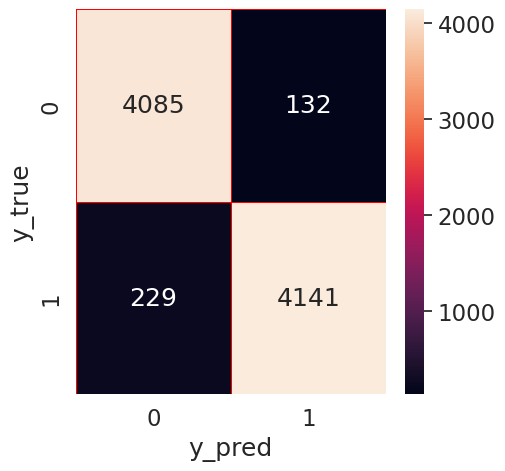

In [ ]:

cm = confusion_matrix(y_test,y_pred)

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

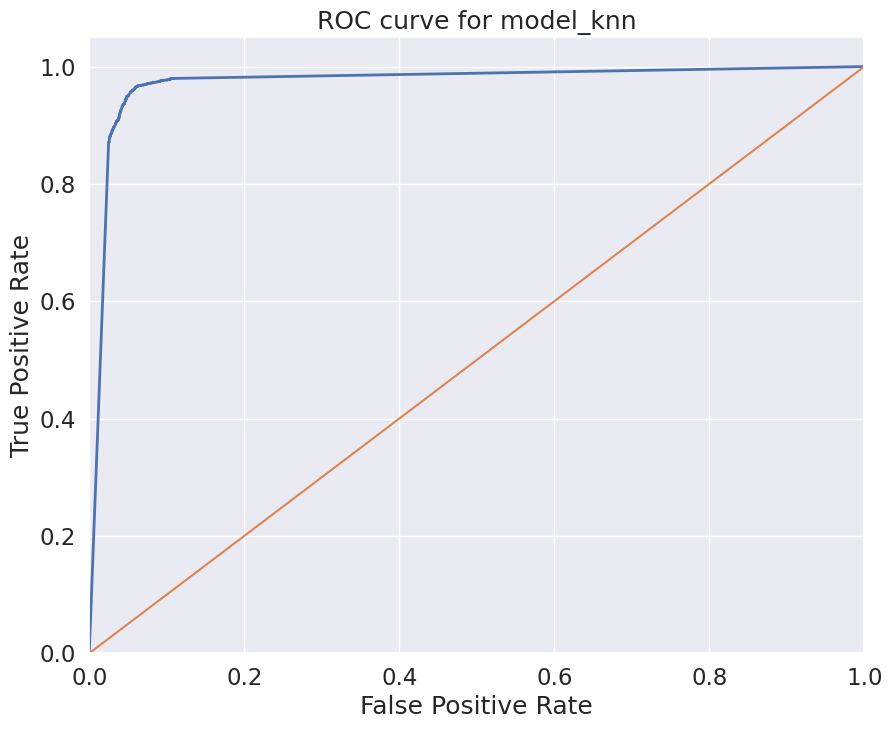

In [ ]:


sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, model_knn.predict_proba(X_test)[:,0], pos_label=0)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for model_knn')
plt.show()

ROC-AUC: 0.9512832172708374


## Метод опорных векторов + Gridsearch

C (регуляризация):
<br> Этот параметр управляет штрафом за неправильно классифицированные точки. <br> Меньшие значения C создают более широкие гиперплоскости, что может привести к ошибкам классификации, но более устойчивым к выбросам.
<br>Большие значения C могут создавать более узкие гиперплоскости, что лучше подстраивается под данные, но может быть более чувствительными к выбросам.

kernel (ядерная функция):
<br>Этот параметр определяет тип функции, используемой для преобразования данных в пространство более высокой размерности. Наиболее распространенными ядрами являются "linear" (линейное), "poly" (полиномиальное) и "rbf" (радиально-базисная функция Гаусса).

gamma (коэффициент ядра):
<br>Этот параметр влияет на форму гиперплоскости. Большое значение делает ядро более "острым", что позволяет модели более точно подстраиваться под каждый обучающий пример. Это может привести к более сложной и гибкой гиперплоскости, которая лучше разделяет классы в данных.
<br>Однако слишком большое значение gamma может также привести к переобучению модели, особенно если данных недостаточно.

In [ ]:
# проецирование наблюдений в n-мерном пр-ве признаков с целью нахождения гиперплоскости, разделяющей наблюдения на классы

clf = SVC()
param_grid = {'C':[0.1, 1, 10, 100], 'gamma':[1, 0.1, 0.01, 0.001] } # 'kernel': ['linear', 'rbf', 'poly'], , 'class_weight': [None, 'balanced']
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 3, random_state = 42)
model_svm = GridSearchCV(clf, param_grid, refit = True, cv = cv, verbose = 3, n_jobs = -1, scoring = 'accuracy', error_score = 0)
model_svm.fit(X_train, y_train)

print("Best: %f using %s" % (model_svm.best_score_, model_svm.best_params_))
means = model_svm.cv_results_['mean_test_score']
stds = model_svm.cv_results_['std_test_score']
params = model_svm.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 9 folds for each of 16 candidates, totalling 144 fits
Best: 0.960411 using {'C': 0.1, 'gamma': 0.001}
0.960066 (0.000847) with: {'C': 0.1, 'gamma': 1}
0.960363 (0.000860) with: {'C': 0.1, 'gamma': 0.1}
0.959903 (0.000733) with: {'C': 0.1, 'gamma': 0.01}
0.960411 (0.000770) with: {'C': 0.1, 'gamma': 0.001}
0.959779 (0.000793) with: {'C': 1, 'gamma': 1}
0.960401 (0.000810) with: {'C': 1, 'gamma': 0.1}
0.960210 (0.000847) with: {'C': 1, 'gamma': 0.01}
0.959903 (0.000745) with: {'C': 1, 'gamma': 0.001}
0.959798 (0.000999) with: {'C': 10, 'gamma': 1}
0.959693 (0.000799) with: {'C': 10, 'gamma': 0.1}
0.960248 (0.000896) with: {'C': 10, 'gamma': 0.01}
0.960181 (0.000818) with: {'C': 10, 'gamma': 0.001}
0.959827 (0.000928) with: {'C': 100, 'gamma': 1}
0.959798 (0.000976) with: {'C': 100, 'gamma': 0.1}
0.959923 (0.000917) with: {'C': 100, 'gamma': 0.01}
0.960248 (0.000963) with: {'C': 100, 'gamma': 0.001}


In [ ]:
y_pred = model_svm.predict(X_test)

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4217
           1       0.97      0.95      0.96      4370

    accuracy                           0.96      8587
   macro avg       0.96      0.96      0.96      8587
weighted avg       0.96      0.96      0.96      8587



In [ ]:
  print(f"ROC-AUC: {roc_auc_score(y_test, y_pred,multi_class='ovo')}")

ROC-AUC: 0.9574445865568644


In [ ]:

# save
with open('model_svm.pkl','wb') as f:
    pickle.dump(model_svm,f)
# load
#with open(''model_svm.pkl', 'rb') as f:
    #clf2 = pickle.load(f)

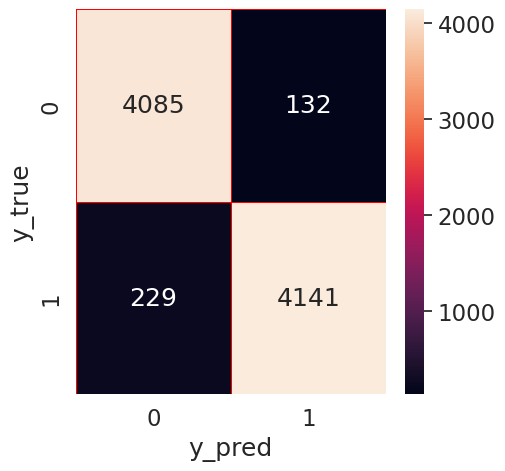

In [ ]:
cm = confusion_matrix(y_test,y_pred)

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

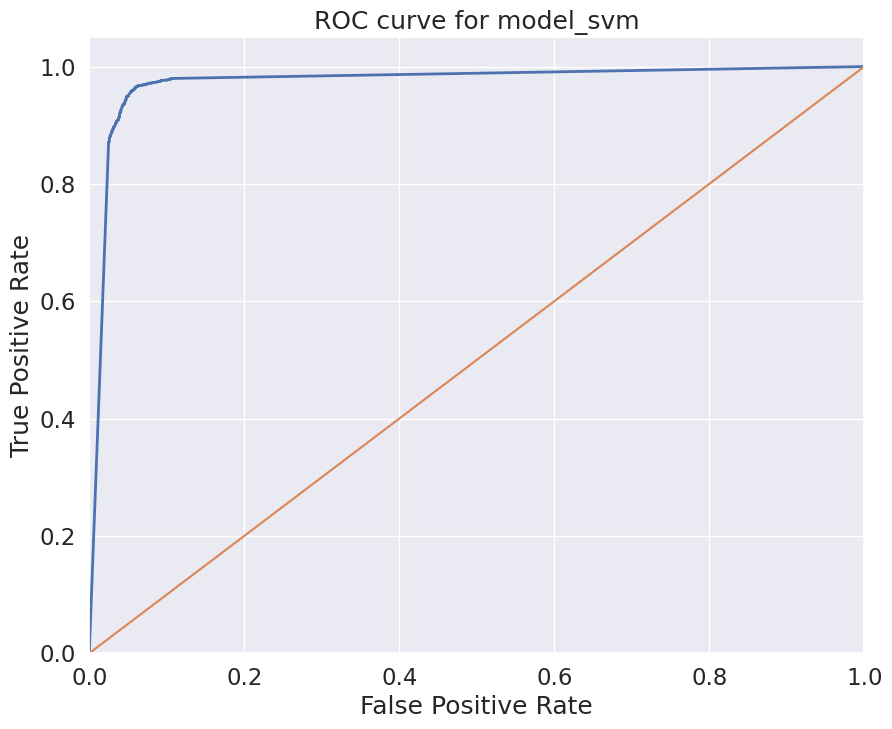

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, model_knn.predict_proba(X_test)[:,0], pos_label=0)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve for')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for model_svm')
plt.show()

In [ ]:
    print(f"ROC-AUC: {roc_auc_score(one_hot_test, one_hot_pred,multi_class='ovo')}")

ROC-AUC: 0.9512832172708374


## Случайный лес + Gridsearch

**Все деревья строятся по следующей схеме**:

* Берется подвыборка обучающей выборки, по ней строится дерево

* Для построения каждого ветвления в дереве просматриваем набор случайных признаков

* Выбираем наилучшие признак и ветвление по нему. Дерево строится до определенной высоты  (не всегда)

"Criterion" позволяет выбрать один из двух критериев для разделения данных при построении каждого дерева:
* entropy - энтропия, измеряет меру неопределенности в данных.
<br>Модель стремится минимизировать ее в каждом узле дерева.
* gini - использует критерий Gini impurity для оценки качества разделения данных.
<br>Gini impurity измеряет, насколько случайно выбранный элемент классифицирован неверно.
<br>Модель стремится минимизировать ее в каждом узле дерева.
<br>

"Max_depth" представляет максимальный уровень (глубину) каждого дерева в модели случайного леса.
<br>None означает, что во время поиска по сетке не устанавливается ограничение на глубину деревьев решений.
<br>Более глубокое дерево показывает хорошие результаты и собирает много информации об обучающих данных.
<br>Однако это может привести к переобучению, если не установить другие параметры модели правильно.

"Max_features" - максимальное количество признаков, которые могут быть рассмотрены при разделении каждого узла дерева. "Разделение узла" означает процесс принятия решения о том, как разделить данные при построении дерева в зависимости от значения одного из признаков.
<br>Этот параметр влияет на производительность и обобщающую способность модели. Например, 'auto' будет учитывать все признаки и может привести к более сложным деревьям, в то время как 'sqrt' и 'log2' ограничивают количество признаков, что может способствовать уменьшению переобучения.

"Min_samples_leaf" - это параметр, который определяет минимальное количество образцов (наблюдений) в листе (конечном узле) дерева решений.
<br>Большие значения способствуют более устойчивым и простым моделям, но могут ухудшить точность классификации.
<br>Маленькие значения могут привести к более сложным моделям, более склонным к переобучению, но могут обеспечить лучшую точность на обучающих данных.
<br>Если значение min_samples_leaf задано как целое число, то узел не будет разделяться, если в нем находится меньше образцов, чем заданное значение. Это позволяет контролировать глубину дерева и уменьшить склонность к переобучению.

"Min_samples_split" - это параметр, который определяет минимальное количество образцов (наблюдений), необходимое для разделения (сплита) узла дерева решений.
<br>Большие значения способствуют более простым моделям и могут уменьшить склонность к переобучению.
<br>Маленькие значения  могут привести к более сложным моделям и более глубоким деревьям, которые могут быть более гибкими в адаптации к данным, но более склонны к переобучению.
<br>Если в узле находится количество образцов, меньшее, чем значение min_samples_split, то разделение этого узла не будет выполняться, и этот узел останется листом (терминальным узлом) дерева.

"N_estimators" - количество деревьев решений в лесу.
<br>Как правило, чем больше деревьев, тем лучше будет обобщающая способность модели, но увеличение числа деревьев также увеличивает вычислительную сложность и может привести к переобучению, если выбирать слишком большое значение.

random_state - это параметр для контроля случайности в процессе обучения и предсказания моделей. Задача random_state - сделать обучение и предсказания воспроизводимыми, то есть гарантировать, что при каждом запуске модели с одним и тем же значением random_state результаты будут одинаковыми.

Значение random_state может быть любым неотрицательным целым числом. Обычно используются положительные целые значения, и часто значение 42 используется как конвенциональное значение random_state в сообществе машинного обучения.

In [ ]:
# использует ансамбль деревьев решений, где кажде из них дает предсказание класса и класс набравший максимальное кол-во голосов будет являться предсказанием
# разделение данных при построении дерева, глубина, кол-во признаков рассматриваемых при разделении каждого узла дерева, кол-во деревьев
param_grid = {'criterion': ['entropy', 'gini'], 'max_depth': [10, 15],'max_features':['auto', 'sqrt', 'log2'], 'n_estimators': [100, 200, 300]} #'min_samples_leaf': [4, 6, 8],'min_samples_split': [5, 7, 10]

clf = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
model_rfc = GridSearchCV(clf, param_grid,refit = True, cv = cv, verbose= 3, n_jobs = -1, scoring = 'accuracy', error_score = 0)
model_rfc.fit(X_train,y_train)

print("Best: %f using %s" % (model_rfc.best_score_, model_rfc.best_params_))
means = model_rfc.cv_results_['mean_test_score']
stds = model_rfc.cv_results_['std_test_score']
params = model_rfc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 15 folds for each of 36 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best: 0.961598 using {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300}
0.961589 (0.001673) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
0.961541 (0.001754) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}
0.961589 (0.001761) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300}
0.961387 (0.001688) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
0.961502 (0.001734) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
0.961550 (0.001721) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
0.961541 (0.001699) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
0.961493 (0.001773) with: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimator

In [ ]:
y_pred = model_rfc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4217
           1       0.97      0.95      0.96      4370

    accuracy                           0.96      8587
   macro avg       0.96      0.96      0.96      8587
weighted avg       0.96      0.96      0.96      8587



In [ ]:

# save
with open('model_rfc.pkl','wb') as f:
    pickle.dump(model_rfc,f)
# load
#with open('model_rfc.pkl', 'rb') as f:
#    clf2 = pickle.load(f)

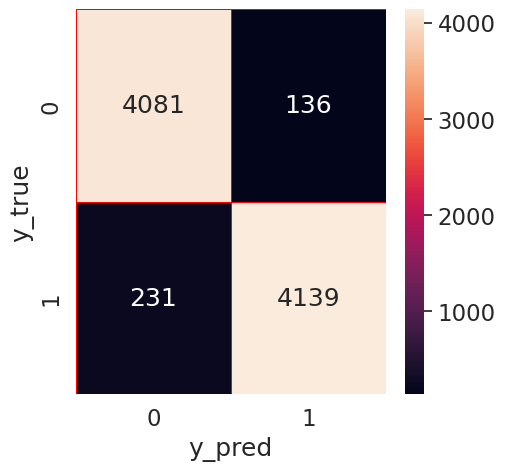

In [ ]:
cm = confusion_matrix(y_test,y_pred)

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

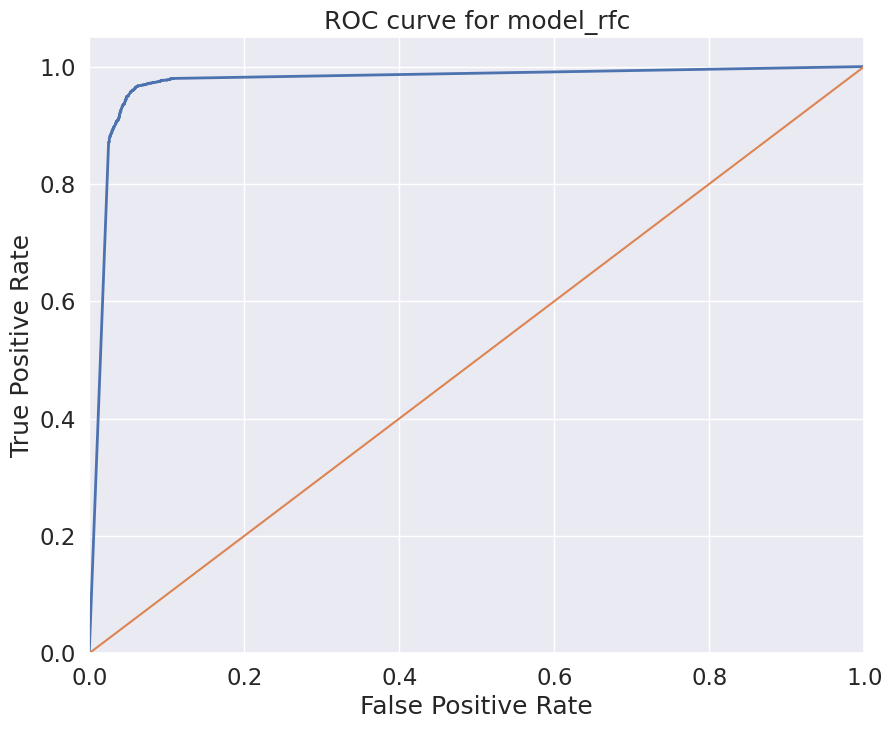

In [ ]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))

fpr, tpr, thresholds = roc_curve(y_test, model_knn.predict_proba(X_test)[:,0], pos_label=0)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve for')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for model_rfc')
plt.show()

In [ ]:
  print(f"ROC-AUC: {roc_auc_score(y_test, y_pred,multi_class='ovo')}")

ROC-AUC: 0.9574445865568644


## Визуализация дерева решений

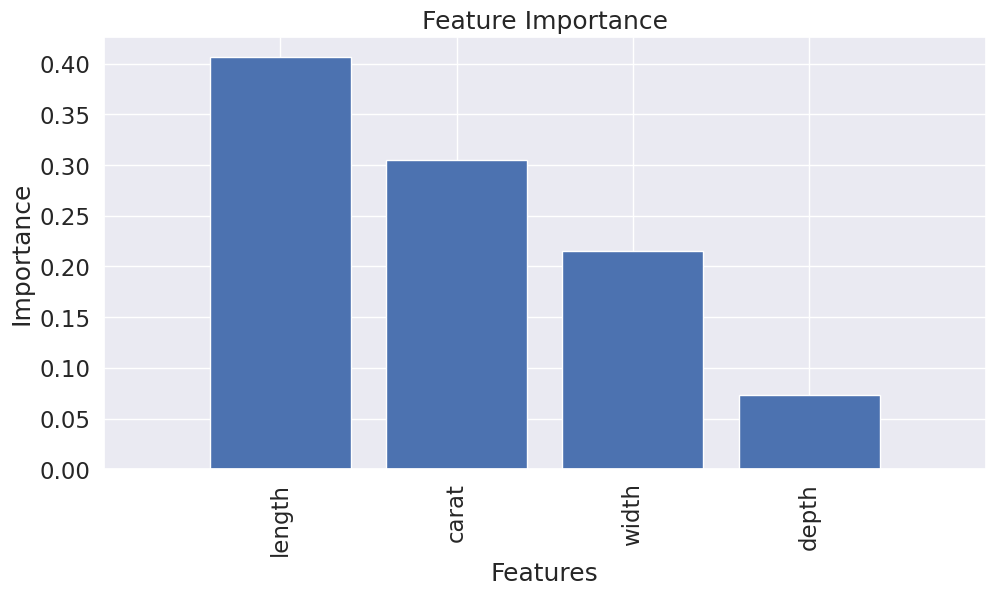

In [ ]:

best_model = model_rfc.best_estimator_


feature_importance = best_model.feature_importances_

feature_names = ['carat', 'length', 'width', 'depth']

sorted_idx = feature_importance.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")

plt.bar(range(len(feature_importance)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlim([-1, len(feature_importance)])


plt.tight_layout()
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()